# EDA Number of renter housing units by income
The notebook presents an EDA over the occupied renter housing units. 

The analysis is similar to the last one, where the number of units distributed by gross rent cost was done. The main difference is that the data was taken from Census.gov (Tenure by renter household income in the past 12 months (inflation-adjusted) by states from 2015 to 2020.

The main goal is to find the distribution of the housing units for rent by household income range because this project focuses on people who have earned a bachelor's degree or above. Therefore, an expected income range is known.

## Grabbing data from Heroku Database

In [91]:
# importing python modules
import pandas as pd
import numpy as np
import seaborn as sns
import connectheroku
import matplotlib.pyplot as plt
from matplotlib import markers

In [92]:
# Some minor styling commands
sns.set_style('whitegrid')
all_shapes = list(markers.MarkerStyle.markers.keys())

In [93]:
# Connecting to Heroku database
credential_path = '/Users/aliglara/Documents/MyGit/apis/credential_keys.json'
cursor = connectheroku.connect_database("c1_capstone", credential_path)

In [94]:
# List of selected states
list_states = ['NY', 'OR', 'CA', 'WA', 'MA', 'CO', 'FL', 'AZ', 'PA', 'GA']

In [95]:
# Queryring the data is needed from database
query = ("SELECT * FROM rent_occupied_by_income "
         " WHERE name_state IN (SELECT sr.name "
         "    FROM state_region AS sr WHERE abbreviation IN ('" + "','".join(list_states)  + "'))")

In [96]:
cursor.execute(query)
results = cursor.fetchall()
cursor.close()

In [97]:
# Renaming columns for better reading
column_names = (['id', 'Year', 'State name', 'Less than $5000',
                 '$5000-$9999', '$10000-$14999', '$15000-$19999',
                 '$20000-$24999', '$25000-$34999', '$35000-$49999',
                 '$50000-$74999', '$75000-$99999', '$100000-$149999',
                 '$150000 or more', 'id_state'])

In [98]:
# Creating the dataframe
df = pd.DataFrame(results, columns=column_names)
df = df.drop(["id"], axis=1)

In [99]:
# This is how the sheet looks like
df.head()

,Year,State name,Less than $5000,$5000-$9999,$10000-$14999,$15000-$19999,$20000-$24999,$25000-$34999,$35000-$49999,$50000-$74999,$75000-$99999,$100000-$149999,$150000 or more,id_state
0,2015,New York,203410,253643,275686,243069,214353,369940,435593,528287,310475,304390,255946,36
1,2015,Oregon,32209,41893,48218,47915,46979,82908,97386,103321,49847,36362,17276,41
2,2015,Pennsylvania,93232,125261,143444,133714,117588,206567,230961,247278,121478,86449,44309,42
3,2015,Washington,48087,56442,66729,62631,67819,119596,166990,189500,106513,93109,47888,53
4,2015,Arizona,59025,55802,71265,68381,74421,127444,149994,165144,80470,61928,24306,4


At this the dataframe presents the number of renter housing units by range income for each selected state from 2015 to 2020.

In [100]:
states = list(df["State name"].unique())
years = list(df["Year"].unique())

In [101]:
# Let reformat the table
df = df.sort_values(by=["Year", "State name"])
df.set_index(["Year", "State name"], inplace=True)

In [102]:
df.head()

Less than $5000  $5000-$9999  $10000-$14999  $15000-$19999  \
Year State name                                                               
2015 Arizona               59025        55802          71265          68381   
     California           262767       246643         457608         378216   
     Colorado              36091        37703          46916          44698   
     Florida              153545       162248         206227         211515   
     Georgia               98645        99425         118086         105479   

                 $20000-$24999  $25000-$34999  $35000-$49999  $50000-$74999  \
Year State name                                                               
2015 Arizona             74421         127444         149994         165144   
     California         394256         678517         845547        1022900   
     Colorado            55531          93721         126006         142550   
     Florida            219848         381360         442636         469972   
     Georgia            117751         182061         216709         232166   

                 $75000-$99999  $100000-$149999  $150000 or more  id_state  
Year State name                                                             
2015 Arizona             80470            61928            24306         4  
     California         636369           618680           444031         6  
     Colorado            75779            65031            28091         8  
     Florida            218197           160908            76657        12  
     Georgia            110638            81807            32474        13

# Visualization of distribution of renter housing units

As before, a bar plot for each state is presented to show the distribution of rented housing units

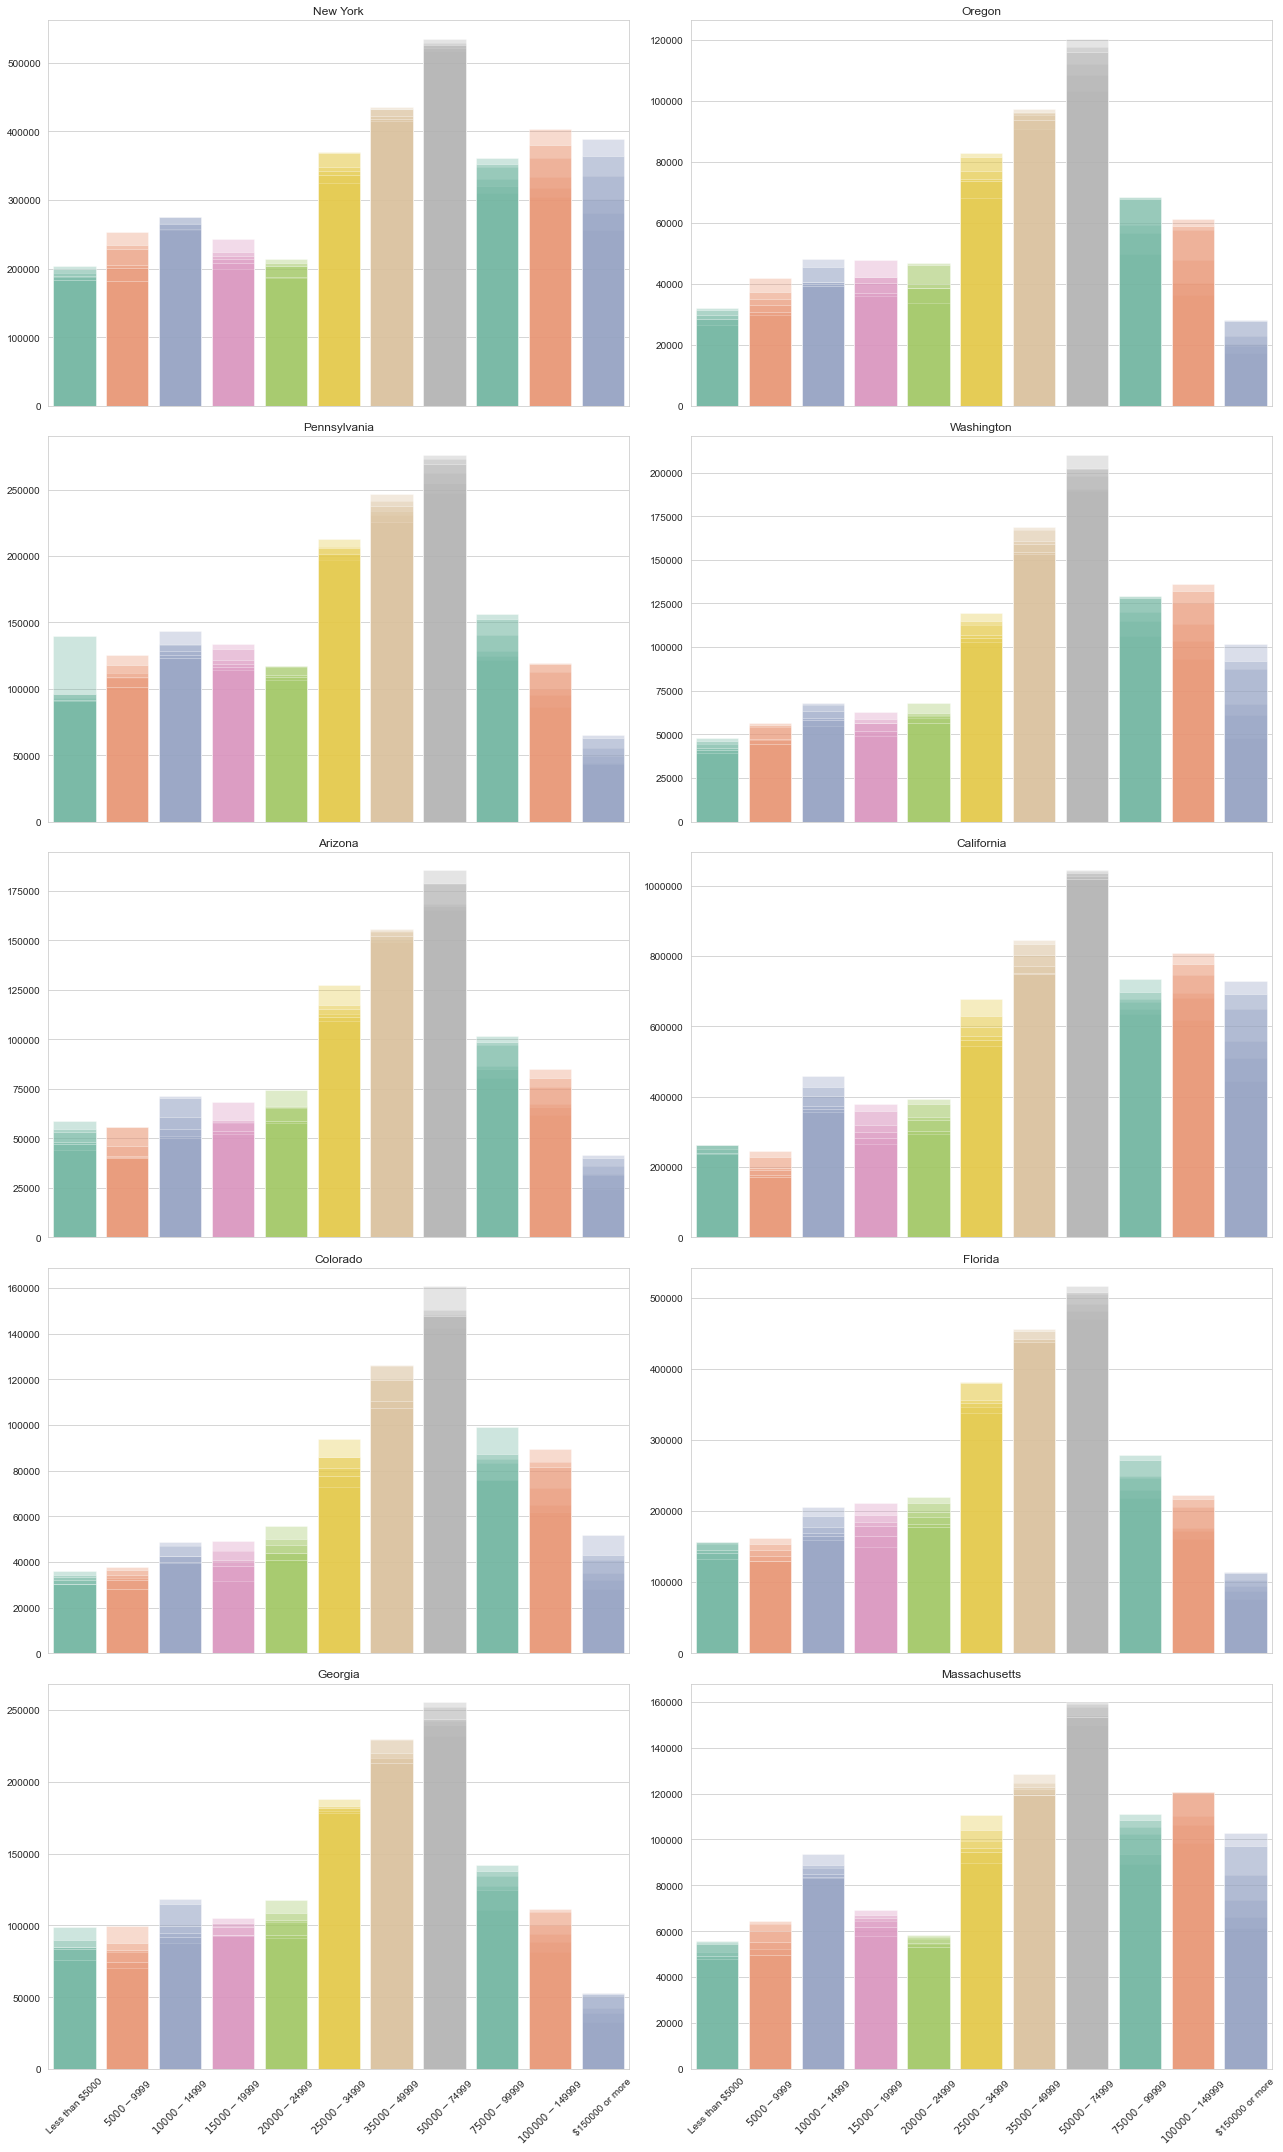

In [103]:
# Create the figure
_, axes = plt.subplots(5, 2, figsize=(18,30), sharex='col')

for state, ax in zip(states, axes.ravel()):
    # The data has to be reformated for the barplot seaborn
    subdata = df.loc(axis=0)[:, state]
    subdata.reset_index(inplace=True)
    subdata = subdata.drop(["id_state", "State name"], axis=1)
    subdata = subdata.T
    subdata.columns = subdata.iloc[0]
    subdata = subdata.drop("Year", axis=0)

    for year in years:
        g = sns.barplot(x=subdata.index, y=subdata[year].values,
                        palette = 'Set2',
                        ax=ax, alpha=0.35)
        g.set_title(state)
        g.tick_params(labelrotation=45, axis='x')
        g.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

Based on the figure, the distribution of rented housing is not the same for all states compared to the previous analysis. However, most units are rented by household income between USD 50,000 and 74,999.
Interestingly, the distribution of rented units for household income of USD 35000 or above in California and New York tends to be uniform. On the other hand, for income range of USD 25000 or less, the distribution of housing units is almost uniform.

Finally, in California, New York, and Massachusetts, the proportion of rented housing units with an income of USD 150,000 or above is significantly higher than in the rest of the studied US-States.

In [104]:
# Back to the original format of the data
df.reset_index(inplace=True)

# Remove id_state because we don't need it
df1 = df.drop("id_state", axis=1)

# Calculation of the portion of each rent cost range
df1 = df1.iloc[:,2:].apply(lambda x: x/x.sum()*100, axis=1)

# Calculation of teh cumulative sum
df1 = df1.apply(lambda x: np.cumsum(x), axis=1)

# Let's create a dataframe
df1 = pd.concat([df[["Year","State name"]], df1], axis=1)
df1.set_index(["Year", "State name"], inplace=True)

In [105]:
df1.head()

Less than $5000  $5000-$9999  $10000-$14999  $15000-$19999  \
Year State name                                                               
2015 Arizona            6.291437    12.239336      19.835426      27.124113   
     California         4.390034     8.510686      16.155919      22.474753   
     Colorado           4.798589     9.811505      16.049365      21.992323   
     Florida            5.680303    11.682567      19.311808      27.136675   
     Georgia            7.070105    14.196114      22.659598      30.219510   

                 $20000-$24999  $25000-$34999  $35000-$49999  $50000-$74999  \
Year State name                                                               
2015 Arizona         35.056599      48.640773      64.628536      82.231128   
     California      29.061567      40.397515      54.524024      71.613560   
     Colorado        29.375616      41.836576      58.590086      77.543255   
     Florida         35.269817      49.377995      65.753041      83.139366   
     Georgia         38.658984      51.707698      67.239710      83.879559   

                 $75000-$99999  $100000-$149999  $150000 or more  
Year State name                                                   
2015 Arizona         90.808374        97.409239            100.0  
     California      82.245344        92.581598            100.0  
     Colorado        87.618682        96.265076            100.0  
     Florida         91.211429        97.164122            100.0  
     Georgia         91.809229        97.672517            100.0

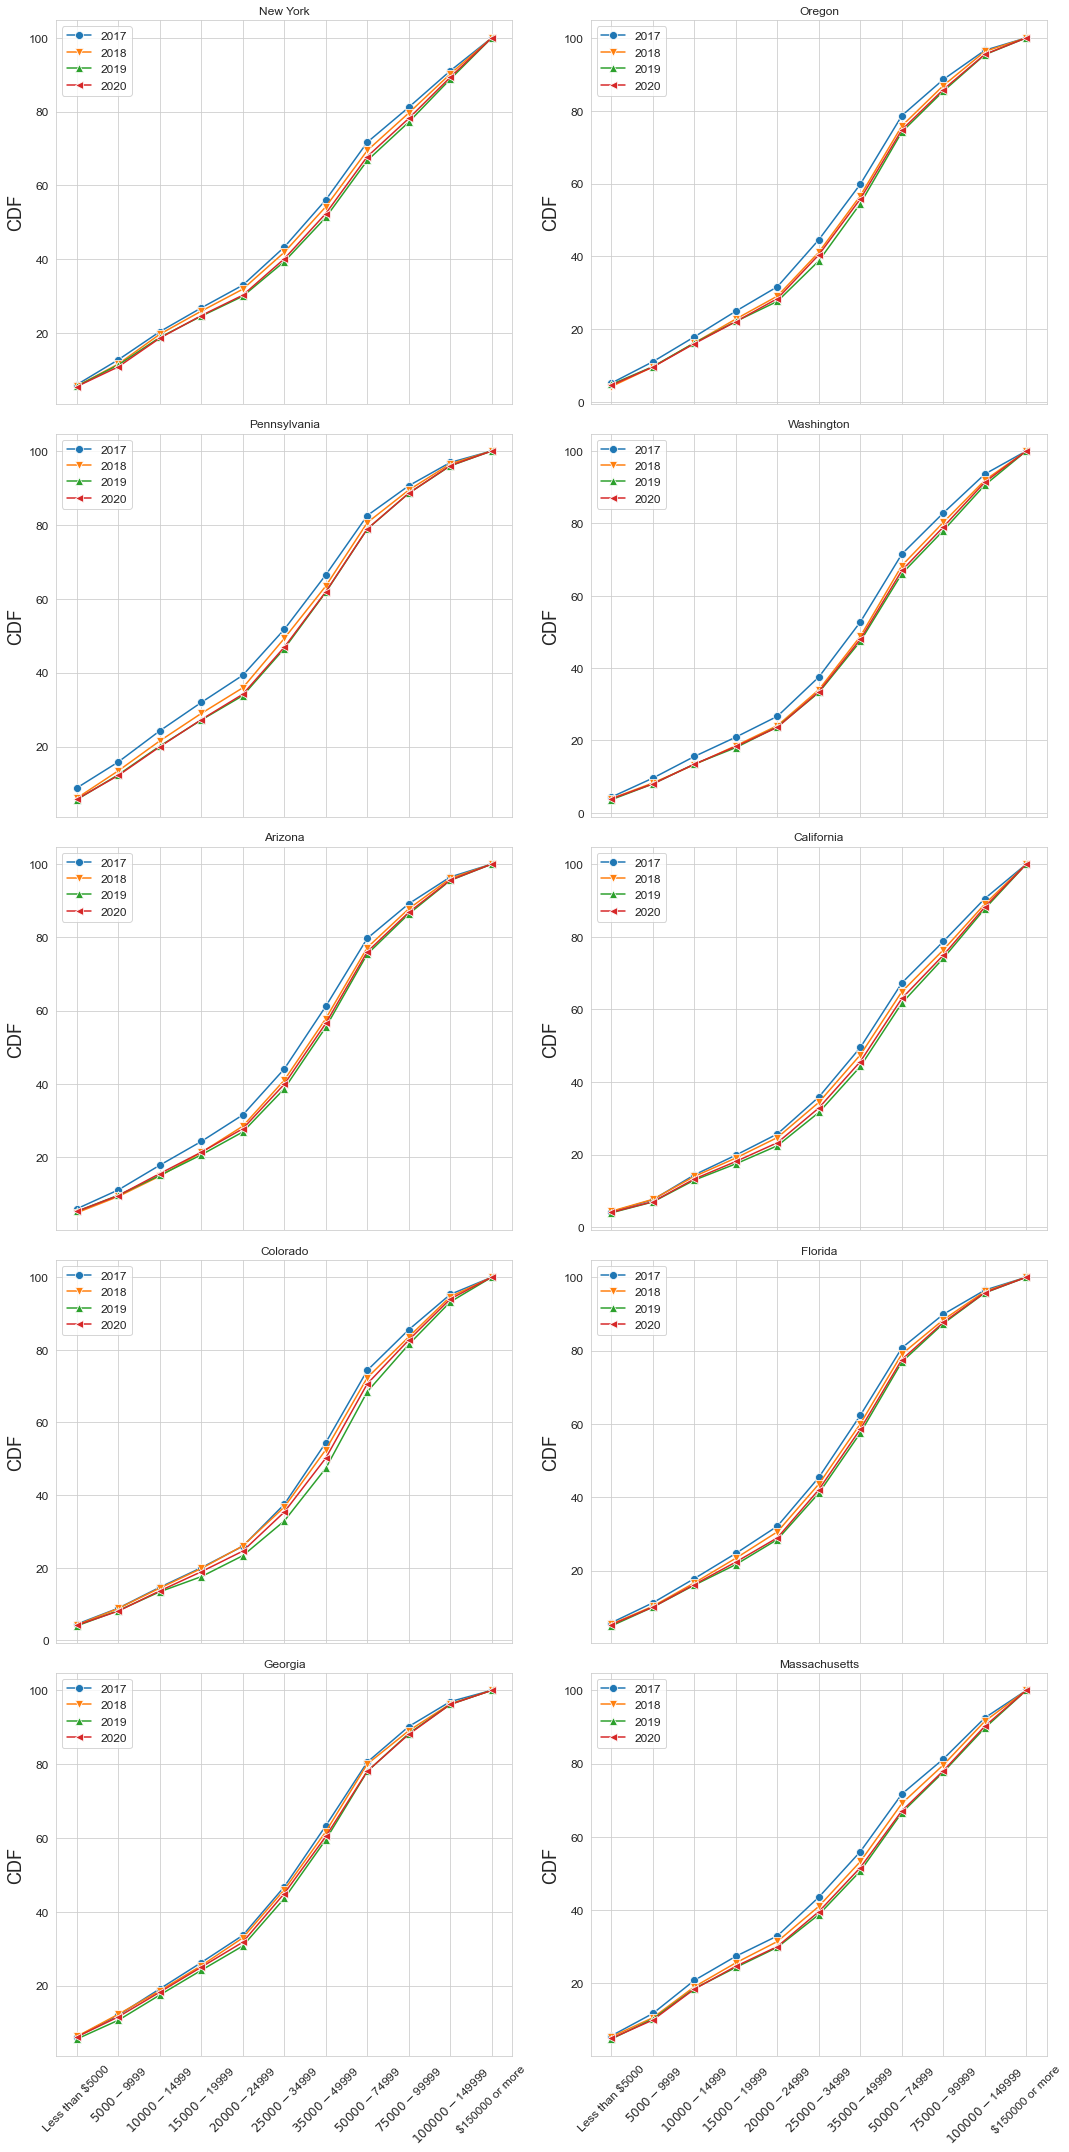

In [106]:
years_short = list(np.arange(2017,2021))
_, axes = plt.subplots(5, 2, figsize=(15,30), sharex='col')

for state, ax in zip(states, axes.ravel()):
    for i, year in enumerate(years_short):
        g = sns.lineplot(data=df1.loc[(year, state)],
                         palette='colorblind', ax=ax, label=year,
                         marker=all_shapes[i+2],
                         markersize=8)
        g.set_title(state)
        g.set_ylabel("CDF", fontsize=18)
        g.tick_params(axis='y', labelsize=12)
        g.tick_params(labelrotation=45, axis='x', labelsize=12)
        g.ticklabel_format(style='plain', axis='y')
        g.legend(fontsize='large')

plt.tight_layout()
plt.show()

As shown in the previous figure, the cumulative distribution of each US-State is almost the same from 2017 to 2020. 
For all the states, the proportion of rented housing units decreased slightly from 2017 to 2018. However, adding information about the house price market would be interesting to check if the number of houses bought increased. 

However, the 2018 to 2020 distribution curves are almost the same in all cases, which means the proportion of rented houses kept the same. Regardless, a remarkable shift in the tendency occurred in 2020, where the proportion increased compared to 2019 for all states, especially in the  USD 25,000 to 50,000 income range.

Several questions can be drawn, for example:
- Are more housing units available for that household income range?
- The household income increased, so more people are renting?
- The increase in rent cost is high, so people who used to rent more expensive units have shifted to more affordable ones?

In [107]:
df

,Year,State name,Less than $5000,$5000-$9999,$10000-$14999,$15000-$19999,$20000-$24999,$25000-$34999,$35000-$49999,$50000-$74999,$75000-$99999,$100000-$149999,$150000 or more,id_state
0,2015,Arizona,59025,55802,71265,68381,74421,127444,149994,165144,80470,61928,24306,4
1,2015,California,262767,246643,457608,378216,394256,678517,845547,1022900,636369,618680,444031,6
2,2015,Colorado,36091,37703,46916,44698,55531,93721,126006,142550,75779,65031,28091,8
3,2015,Florida,153545,162248,206227,211515,219848,381360,442636,469972,218197,160908,76657,12
4,2015,Georgia,98645,99425,118086,105479,117751,182061,216709,232166,110638,81807,32474,13
5,2015,Massachusetts,55090,63316,93793,69078,56758,110612,124389,157882,89278,98309,61493,25
6,2015,New York,203410,253643,275686,243069,214353,369940,435593,528287,310475,304390,255946,36
7,2015,Oregon,32209,41893,48218,47915,46979,82908,97386,103321,49847,36362,17276,41
8,2015,Pennsylvania,93232,125261,143444,133714,117588,206567,230961,247278,121478,86449,44309,42
9,2015,Washington,48087,56442,66729,62631,67819,119596,166990,189500,106513,93109,47888,53


In [108]:
subdata = df[(df["Year"] == 2019) | (df["Year"] == 2020)].iloc[:, [0, 1, 7, 8, 9]]
pd.pivot_table(data=subdata,
               index="State name",
               columns="Year")

$25000-$34999         $35000-$49999         $50000-$74999  \
Year                   2019    2020          2019    2020          2019   
State name                                                                
Arizona              109492  111320        155660  152232        185358   
California           545487  562032        751801  747735       1035274   
Colorado              73011   77651        110697  107303        160864   
Florida              337616  352222        438067  442012        516471   
Georgia              178083  181628        219840  212870        255701   
Massachusetts         89652   94697        119355  119366        159921   
New York             325378  335882        414625  417316        534883   
Oregon                68084   73620         96298   93765        120352   
Pennsylvania         205984  201697        246911  237659        276478   
Washington           102914  105126        153085  154729        202341   

                        
Year              2020  
State name              
Arizona         179077  
California     1019318  
Colorado        147626  
Florida         508067  
Georgia         243544  
Massachusetts   153367  
New York        526163  
Oregon          115913  
Pennsylvania    269615  
Washington      202831

The Pivot table shows that, except for Washington State, the number of rented units increased for the USD 25,000-350000 income range, while for the USD 35,000 to 75,000 range decreased.